# Utils

In [24]:
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchinfo import summary
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


In [2]:
from lab1_utils import train_loop_sched, count_trainable_parameters, save_to_json
from lab1_utils import train, test, get_lr
from lab1_utils import multiple_diagnostic, test_class

In [20]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# batch_size = 64
batch_size = 128
max_epochs = 20

opt_dict = dict(lr=0.01, momentum=0.9, nesterov=True, weight_decay=5e-4)

criterion = nn.CrossEntropyLoss()

In [31]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # some augmentation
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    # transforms.Resize(224)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    # transforms.Resize(224)
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

# create a split for train/validation. We can use early stop
trainset, valset = torch.utils.data.random_split(dataset, [40000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2,
                                          drop_last=True, pin_memory=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2,
                                        drop_last=False, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2,
                                         drop_last=False, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


# Exercise 1

Scegliamo di usare `resnet18`

Due prove di fine-tuning:
- Modificare il layer finale di classificazione in `resnet18_1` partendo dai pesi originali cercando di arrivare alle migliori performance possibili
- Mettere in coda un MLP in `resnet18_2`
- Addestrare la classification head e il `layer4` in `resnet18_3`

In [5]:
head_loss_acc = {}

## Full network training

In [32]:
resnet18_1 = models.resnet18(weights="DEFAULT")

resnet18_1.fc = nn.Linear(resnet18_1.fc.in_features, 10)
resnet18_1 = resnet18_1.to(device)

# print(summary(resnet18))
print(f"Trainable parameters: {count_trainable_parameters(resnet18_1)}")

Trainable parameters: 11181642


Train with no augmentation

In [22]:
optimizer = optim.SGD(resnet18_1.parameters(), **opt_dict)
# scheduler = ExponentialLR(optimizer, 0.7)
scheduler = MultiStepLR(optimizer, [5, 10, 15], 0.1)

stats = train_loop_sched(trainloader, testloader, resnet18_1, criterion, device, optimizer, scheduler, max_epochs)

head_loss_acc["Full"] = [stats[0], stats[3]]

print("=========")
test_class(resnet18_1, device, criterion, testloader, classes)

Epoch: 1, Learning rate: 0.010000
Training - Loss: 0.9119, Accuracy: 0.687, Runtime: 12.39
Test - Loss: 0.6667, Accuracy: 0.769
Epoch: 2, Learning rate: 0.010000
Training - Loss: 0.5443, Accuracy: 0.814, Runtime: 12.66
Test - Loss: 0.6370, Accuracy: 0.785
Epoch: 3, Learning rate: 0.010000
Training - Loss: 0.3902, Accuracy: 0.866, Runtime: 12.46
Test - Loss: 0.6309, Accuracy: 0.792
Epoch: 4, Learning rate: 0.010000
Training - Loss: 0.3075, Accuracy: 0.894, Runtime: 12.56
Test - Loss: 0.6474, Accuracy: 0.801
Epoch: 5, Learning rate: 0.010000
Training - Loss: 0.2479, Accuracy: 0.914, Runtime: 12.39
Test - Loss: 0.6642, Accuracy: 0.801
Epoch: 6, Learning rate: 0.001000
Training - Loss: 0.1006, Accuracy: 0.968, Runtime: 12.39
Test - Loss: 0.6155, Accuracy: 0.828
Epoch: 7, Learning rate: 0.001000
Training - Loss: 0.0553, Accuracy: 0.983, Runtime: 12.63
Test - Loss: 0.6578, Accuracy: 0.830
Epoch: 8, Learning rate: 0.001000
Training - Loss: 0.0355, Accuracy: 0.991, Runtime: 12.58
Test - Loss: 

Train with horizontal flip augmentation

In [29]:
optimizer = optim.SGD(resnet18_1.parameters(), **opt_dict)
# scheduler = ExponentialLR(optimizer, 0.7)
scheduler = MultiStepLR(optimizer, [5, 10, 15], 0.1)

stats = train_loop_sched(trainloader, testloader, resnet18_1, criterion, device, optimizer, scheduler, max_epochs)

head_loss_acc["Full-Aug1"] = [stats[0], stats[3]]

print("=========")
test_class(resnet18_1, device, criterion, testloader, classes)

Epoch: 1, Learning rate: 0.010000
Training - Loss: 0.9192, Accuracy: 0.686, Runtime: 12.40
Test - Loss: 0.6855, Accuracy: 0.761
Epoch: 2, Learning rate: 0.010000
Training - Loss: 0.5797, Accuracy: 0.802, Runtime: 12.54
Test - Loss: 0.6602, Accuracy: 0.777
Epoch: 3, Learning rate: 0.010000
Training - Loss: 0.4683, Accuracy: 0.840, Runtime: 12.56
Test - Loss: 0.5666, Accuracy: 0.807
Epoch: 4, Learning rate: 0.010000
Training - Loss: 0.3995, Accuracy: 0.863, Runtime: 12.65
Test - Loss: 0.5871, Accuracy: 0.807
Epoch: 5, Learning rate: 0.010000
Training - Loss: 0.3522, Accuracy: 0.877, Runtime: 12.59
Test - Loss: 0.5629, Accuracy: 0.818
Epoch: 6, Learning rate: 0.001000
Training - Loss: 0.2174, Accuracy: 0.928, Runtime: 12.66
Test - Loss: 0.5038, Accuracy: 0.839
Epoch: 7, Learning rate: 0.001000
Training - Loss: 0.1699, Accuracy: 0.943, Runtime: 12.62
Test - Loss: 0.5192, Accuracy: 0.842
Epoch: 8, Learning rate: 0.001000
Training - Loss: 0.1452, Accuracy: 0.952, Runtime: 12.57
Test - Loss: 

Train with horizontal flip and crop augmentations

In [41]:
optimizer = optim.SGD(resnet18_1.parameters(), **opt_dict)
# scheduler = ExponentialLR(optimizer, 0.7)
scheduler = MultiStepLR(optimizer, [5, 10, 15], 0.1)

stats = train_loop_sched(trainloader, testloader, resnet18_1, criterion, device, optimizer, scheduler, max_epochs)

head_loss_acc["Full-Aug2"] = [stats[0], stats[3]]

print("=========")
test_class(resnet18_1, device, criterion, testloader, classes)

Epoch: 1, Learning rate: 0.010000
Training - Loss: 1.0667, Accuracy: 0.632, Runtime: 13.25
Test - Loss: 0.7996, Accuracy: 0.725
Epoch: 2, Learning rate: 0.010000
Training - Loss: 0.7402, Accuracy: 0.747, Runtime: 13.20
Test - Loss: 0.6987, Accuracy: 0.762
Epoch: 3, Learning rate: 0.010000
Training - Loss: 0.6429, Accuracy: 0.782, Runtime: 12.95
Test - Loss: 0.6709, Accuracy: 0.782
Epoch: 4, Learning rate: 0.010000
Training - Loss: 0.5847, Accuracy: 0.800, Runtime: 13.21
Test - Loss: 0.6080, Accuracy: 0.793
Epoch: 5, Learning rate: 0.010000
Training - Loss: 0.5384, Accuracy: 0.814, Runtime: 13.24
Test - Loss: 0.5797, Accuracy: 0.804
Epoch: 6, Learning rate: 0.001000
Training - Loss: 0.4322, Accuracy: 0.851, Runtime: 13.17
Test - Loss: 0.4792, Accuracy: 0.838
Epoch: 7, Learning rate: 0.001000
Training - Loss: 0.3989, Accuracy: 0.861, Runtime: 13.03
Test - Loss: 0.4711, Accuracy: 0.842
Epoch: 8, Learning rate: 0.001000
Training - Loss: 0.3825, Accuracy: 0.868, Runtime: 13.50
Test - Loss: 

Show performance. As expected when adding augmentations the loss requires far more epochs to converge to 0 but we see that at the 10th epoch stabilizes. On the other hand, the test accuracy when adding augmentations increses a bit result in better generalization capacbility of the model.

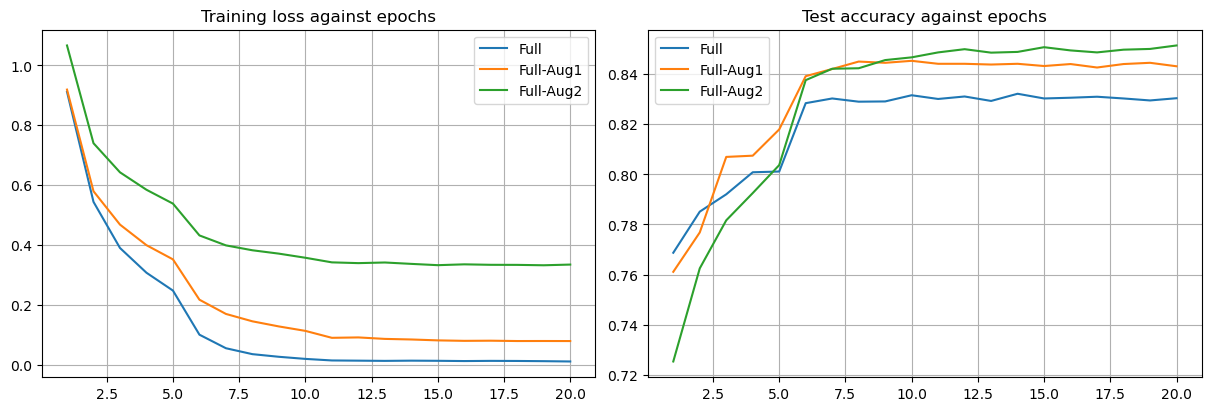

In [42]:
multiple_diagnostic(head_loss_acc, max_epochs)
plt.savefig("./plots/cifar10-resnet-aug.pdf")

In [55]:
# head_loss_acc_converted = {k: [[float(x) for x in seq] for seq in v] for k, v in head_loss_acc.items()}

# import json
# with open("./plots/cifar10-resnet.json", "w") as file:
#     json.dump(head_loss_acc_converted, file)
# type(head_loss_acc_converted["Full"][0][0])

save_to_json("./plots/cifar10-resnet-aug.json")

## Classification head: linear

In [15]:
## Init model
resnet18_2 = models.resnet18(weights="DEFAULT")

## Random init weights for classification head
resnet18_2.fc = nn.Linear(resnet18_2.fc.in_features, 10)

## Default init weights for classification head
# im_weights = resnet18_2.fc.weight[:10]
# resnet18_2.fc.weight.data = im_weights.data

## Send model to `device`
resnet18_2 = resnet18_2.to(device)

# print(resnet18_1)
# print(resnet18_1.fc.weight.data)
# print(summary(resnet18_1))

In [17]:
## Freeze all layers
for param in resnet18_2.parameters():
    param.requires_grad = False

## let final layer be trainable, that goes into classification head
resnet18_2.fc.weight.requires_grad = True
resnet18_2.fc.bias.requires_grad = True
# resnet18_2.fc.requires_grad = True

print(f"Trainable parameters: {count_trainable_parameters(resnet18_2)}")
# print(summary(resnet18_1))

Trainable parameters: 5130


Train linear classification head with SGD using exponential scheduler

In [13]:
optimizer = optim.SGD(resnet18_1.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = ExponentialLR(optimizer, 0.8)

stats = train_loop_sched(trainloader, valloader, resnet18_1, criterion, device,
                         optimizer, scheduler, max_epochs)

head_loss_acc["Linear"] = [stats[0], stats[3]]

print("=========")
test_class(resnet18_1, device, criterion, valloader, classes)

Epoch: 1, Learning rate: 0.100000
Training - Loss: 4.0132, Accuracy: 0.66, Runtime: 48.08
Test - Loss: 3.6889, Accuracy: 0.68
Epoch: 2, Learning rate: 0.080000
Training - Loss: 2.3707, Accuracy: 0.70, Runtime: 48.53
Test - Loss: 2.5345, Accuracy: 0.68
Epoch: 3, Learning rate: 0.064000
Training - Loss: 1.9399, Accuracy: 0.72, Runtime: 48.47
Test - Loss: 1.9044, Accuracy: 0.71
Epoch: 4, Learning rate: 0.051200
Training - Loss: 1.6157, Accuracy: 0.72, Runtime: 48.55
Test - Loss: 1.7710, Accuracy: 0.70
Epoch: 5, Learning rate: 0.040960
Training - Loss: 1.3378, Accuracy: 0.74, Runtime: 48.59
Test - Loss: 1.7165, Accuracy: 0.67
Epoch: 6, Learning rate: 0.032768
Training - Loss: 1.1797, Accuracy: 0.74, Runtime: 48.33
Test - Loss: 1.3215, Accuracy: 0.71
Done! - Runtime: 384.67 seconds
Accuracy for class: plane is 60.5 %
Accuracy for class: car   is 86.9 %
Accuracy for class: bird  is 75.6 %
Accuracy for class: cat   is 26.9 %
Accuracy for class: deer  is 43.8 %
Accuracy for class: dog   is 82.

## Classification head: MLP

In [8]:
## Init model
resnet18_2 = models.resnet18(weights="DEFAULT")

## Add MLP
resnet18_2.fc = nn.Sequential(
    nn.Linear(512, 64),
    nn.ReLU(),
    nn.Linear(64, 10)  # logits
)

## Send model to `device`
resnet18_2 = resnet18_2.to(device)

# print(resnet18_2)
# print(summary(resnet18_2))

In [9]:
## Freeze all layers
for param in resnet18_2.parameters():
    param.requires_grad = False

## Let final layer be trainable, that goes into classification head
# random initialization
for param in resnet18_2.fc.parameters():
    param.requires_grad = True

print(f"Trainable parameters: {count_trainable_parameters(resnet18_2)}")
# print(summary(resnet18_2))

Trainable parameters: 33482


Train MLP classification head with SGD using exponential scheduler

In [10]:
optimizer = optim.SGD(resnet18_2.parameters(), lr=0.1, momentum=0.9)
scheduler = ExponentialLR(optimizer, 0.8)

stats = train_loop_sched(trainloader, valloader, resnet18_2, criterion, device,
                         optimizer, scheduler, max_epochs)

head_loss_acc["MLP"] = [stats[0], stats[3]]

print("=========")
test_class(resnet18_2, device, criterion, valloader, classes)

Epoch: 1, Learning rate: 0.100000
Training - Loss: 1.9092, Accuracy: 0.29, Runtime: 48.89
Test - Loss: 2.1788, Accuracy: 0.19
Epoch: 2, Learning rate: 0.080000
Training - Loss: 1.9047, Accuracy: 0.28, Runtime: 49.13
Test - Loss: 1.8783, Accuracy: 0.27
Epoch: 3, Learning rate: 0.064000
Training - Loss: 1.9014, Accuracy: 0.28, Runtime: 49.22
Test - Loss: 1.7281, Accuracy: 0.34
Epoch: 4, Learning rate: 0.051200
Training - Loss: 1.7695, Accuracy: 0.31, Runtime: 49.22
Test - Loss: 1.9628, Accuracy: 0.30
Epoch: 5, Learning rate: 0.040960
Training - Loss: 1.6589, Accuracy: 0.35, Runtime: 48.86
Test - Loss: 1.7467, Accuracy: 0.34
Epoch: 6, Learning rate: 0.032768
Training - Loss: 1.4766, Accuracy: 0.44, Runtime: 48.28
Test - Loss: 1.2134, Accuracy: 0.56
Done! - Runtime: 388.05 seconds
Accuracy for class: plane is 73.7 %
Accuracy for class: car   is 65.8 %
Accuracy for class: bird  is 46.4 %
Accuracy for class: cat   is 48.9 %
Accuracy for class: deer  is 52.1 %
Accuracy for class: dog   is 71.

## Classification head + previous layer

In [8]:
## Init model
resnet18_1 = models.resnet18(weights="DEFAULT")

## Random init weights for classification head
resnet18_1.fc = nn.Linear(resnet18_1.fc.in_features, 10)
## Default init weights for classification head
im_weights = resnet18_1.fc.weight[:10]
resnet18_1.fc.weight.data = im_weights.data

## Send model to `device`
resnet18_1 = resnet18_1.to(device)

# print(resnet18_1)
# print(resnet18_1.fc.weight.data)
# print(summary(resnet18_1))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
## Freeze all layers
for param in resnet18_1.parameters():
    param.requires_grad = False

## let final layer be trainable, that goes into classification head
resnet18_1.fc.requires_grad = True

## Let also one previous layer to be trainable
for param in resnet18_1.layer4.parameters():
    param.requires_grad = True

print(f"Trainable parameters: {count_trainable_parameters(resnet18_1)}")
# print(summary(resnet18_1))

Trainable parameters: 8393728


# Exercise 2

Cambiare il learning rate dei layer finali oppure mettere trainable un layer di convoluzione interno e cambiargli learning rate

# Exercise 3

Model selection strategy??